In [77]:
from monai import transforms
import numpy as np
from scipy import sparse
import torch
from skimage import measure
import matplotlib.pyplot as plt
import ast

torch.Size([1, 1024, 202])


AttributeError: AxesImage.set() got an unexpected keyword argument 'figsize'

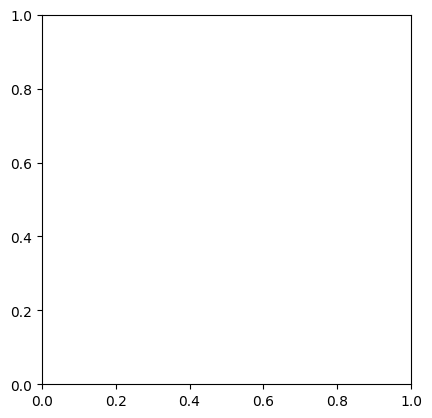

In [86]:
image = np.load('./example_image/image.npy')
image = torch.from_numpy(image)

print(image[:, 5, :].shape)

plt.imshow(image[:, 200, :].squeeze(), figsize=(10, 10),cmap='gray')

# mask_file = './example_image/mask_(47, 512, 512, 172).npz'
# mask = sparse.load_npz(mask_file)
# gt_shape = ast.literal_eval(mask_file.split('.')[-2].split('_')[-1])
# mask_array = mask.toarray().reshape(gt_shape).astype(np.int32)
# print(mask_array.shape)

# mask = torch.from_numpy(mask_array)

In [66]:
# resize = transforms.Resize((256, 256, 256))
# mask = resize(mask)
# image = resize(image)
# print(mask.shape, image.shape)

In [88]:
print({organ:idx for idx, organ in enumerate(['A', 'B', 'C'])})

{'A': 0, 'B': 1, 'C': 2}


In [67]:
# Try the following : remove all slices that are entirely filled with zero's from all directions
# Leaving you with a cube where the organ fits in exactly. keep track of how many slices you remove
# from each side, such that we can add them afterwards, or we can use them to determine the middle.

def rotate_organ(image:torch.tensor, mask:torch.tensor, x_range=90, y_range=90, z_range=90, prob=1.0):
    # instantiate random rotation class from monai
    rotate = transforms.RandRotate(range_x=x_range, range_y=y_range, range_z=z_range, prob=prob)

    # Get all the pixel values of the organ, and set the rest to zero
    organ_pixels = (image * mask)

    # Get a flipped mask with zeros at mask
    flipped_mask = ~mask

    # Remove the organ from the original volume by masking it and keeping all other pixel values the same
    image_without_organ = image*flipped_mask

    # Rotate the organ pixels randomly (the augmentation)
    rotated_organ = rotate(organ_pixels) 

    # Check which locations in the volumne are left empty due to the augmentation

    # 1 where the rotated organ is zero, else 0
    no_organ_rotated_mask = rotated_organ==0
    # 1 where the image with removed organ is zero, else 0
    no_organ_im_without_organ = image_without_organ==0
    # also include the original mask to not fill in other black spots in the image
    neither = (no_organ_rotated_mask*no_organ_im_without_organ*mask)

    # flip the mask to have zero for the small portion and one for the entire image
    neither_flipped = ~neither

    # get the indices of the small patch(es) to fill in.
    indices_to_fill_in = torch.where(neither_flipped==0)

    # Get the original image, with the small gap(s) to fill in left black
    to_fill_in_masked = image*neither_flipped

    # # while there exists indices of the patch to fill in that are zero, dilate using maxpool3D
    # while torch.sum( (to_fill_in_masked[indices_to_fill_in]==0) ) != 0:
    #     # Dilate tensor using maxpool3D
    #     dilated_tensor = torch.nn.functional.max_pool3d(to_fill_in_masked.unsqueeze(0), kernel_size=3, stride=1, padding=1)[0]

    #     # adjust the image that is filled
    #     to_fill_in_masked = torch.where(neither_flipped==1, to_fill_in_masked, dilated_tensor)
    
    # remove all pixel values for the rotated organ
    to_fill_in_masked *= no_organ_rotated_mask
    # add the rotated organ
    to_fill_in_masked += rotated_organ


    return to_fill_in_masked

rotated_organ = rotate_organ(image, mask[4])


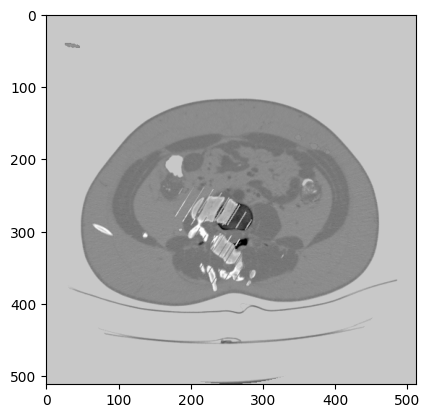

In [68]:
plt.imshow(rotated_organ[:, :, :, 100].squeeze(), cmap='gray')


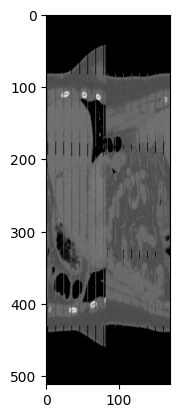

In [74]:
plt.imshow(image[:,  200, ].squeeze(), cmap='gray')

In [70]:
from monai.visualize.utils import matshow3d

In [71]:
# Loading mesh data for visualization
original_mesh_data = measure.marching_cubes(image.squeeze().numpy(), level=0)
transformed_mesh_data = measure.marching_cubes(rotated_organ.squeeze().numpy(), level=0)

# Visualization function for 3D mesh
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d_mesh(verts, faces, imshape=image.shape,  title='3D Mesh'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlim(0, imshape[0])
    ax.set_ylim(0, imshape[1])
    ax.set_zlim(0, imshape[2])
    ax.set_title(title)
    plt.axis('off')
    plt.show()
